In [1]:
import pandas as pd
import numpy as np
import ppscore as pps
import statsmodels as sm
import time
from sklearn.model_selection import KFold
from sklearn.utils import class_weight, compute_class_weight
MAX_EVALS = 500
N_FOLDS = 10

In [2]:

pd.set_option('display.max_columns', None)
df_td = pd.read_csv('tic_2000_train_data.csv')
eval1 = pd.read_csv('tic_2000_eval_data.csv')
target = pd.read_csv('tic_2000_target_data.csv')



#First looking at the data, it is evident there is a definate imbalnace in the target variable
#Due to the heavy imbalance, I will first try to isolate the features that are directly related to the target
# variable, and then unbalance the data set and use a backwards elimination process to further trim down the features.
print('Target feature in Training Data; Balance', '\n',df_td.CARAVAN.value_counts())
print('Target feature in Target Data; Balance', '\n',target.Target.value_counts())
#No missing values, and all equal head counts.
print('Training Features Dataset; Shape', df_td.shape)
print('Eval Features Dataset; Shape', eval1.shape)
print('Target Feature Dataset; Shape', target.shape)
#https://www.kaggle.com/kushshah95/the-insurance-company-tic-benchmark

Target feature in Training Data; Balance 
 0    5474
1     348
Name: CARAVAN, dtype: int64
Target feature in Target Data; Balance 
 0    3762
1     238
Name: Target, dtype: int64
Training Features Dataset; Shape (5822, 86)
Eval Features Dataset; Shape (4000, 85)
Target Feature Dataset; Shape (4000, 1)


# First thoughts:

This is an imbalanced class problem since there are more observations where there is no insurance policy (0) compared to where there is an insurance policy (1). This being the case, ROC and AUC becomes an important factor in how we determine accuracy. A resampling method such as upsampling/downsampling, can be used on the majority observation to deal with this issue as well.


### In this problem, I will use resampling, hyperparameter tuning, and feature selection to achieve better results

In [3]:
#renaming variables to easy reading
df_td.rename(columns={'MOSTYPE': 'subtype_L0', 'MAANTHUI':'Num_houses', 'MGEMOMV' : 'Avg_hh_size',
                   'MGEMLEEF':'age_L1', 'MOSHOOFD': 'maintype_L2', 'MGODRK': 'romcath_L3',
                   'MGODPR': 'Protestant','MGODOV' : 'O_religion', 'MGODGE': 'N_religion','MRELGE' :'Married',
                   'MRELSA' : 'Living_together','MRELOV' : 'O_relation','MFALLEEN' : 'Singles','MFGEKIND' : 'hh_wo_child',
                   'MFWEKIND' : 'hh_w_child','MOPLHOOG' : 'H_lvl_edu','MOPLMIDD' : 'M_lvl_edu',
                   'MOPLLAAG' : 'L_lvl_edu','MBERHOOG' : 'H_status','MBERZELF' : 'Entrepreneur','MBERBOER' : 'Farmer',
                   'MBERMIDD' : 'Mid_management','MBERARBG' : 'Skld_labor','MBERARBO' : 'Unskld_labor',
                   'MSKA' : 'Soc_cls_A','MSKB1' : 'Soc_cls_B1','MSKB2' : 'Soc_cls_B2','MSKC' : 'Soc_cls_C',
                   'MSKD' : 'Soc_cls_D','MHHUUR' : 'R_house','MHKOOP' : 'O_house','MAUT1' : '1_car','MAUT2' : '2_cars',
                   'MAUT0' : 'N_car','MZFONDS' : 'Nat_Hlth_Serv','MZPART' : 'Prv_Hlth_Insur','MINKM30' : 'Inc_u_30k',
                   'MINK3045' : 'Inc_btw_30_45k','MINK4575' : 'Inc_btw_45_75k','MINK7512' : 'Inc_75_122k','MINK123M' : 'Inc_ovr_123k',
                   'MINKGEM' : 'Avg_inc','MKOOPKLA' : 'PP_cls','PWAPART' : 'Contri_prv_3p_insur_L4','PWABEDR' : 'Firm_Contri_3p_ insur',
                   'PWALAND' : 'Ag_Contri_3p_insur','PPERSAUT' : 'Contri_car_pol','PBESAUT' : 'Contri_deliv_van_pol',
                   'PMOTSCO' : 'Contri_motorcycle/scooter_pol','PVRAAUT' : 'Contri_lorry_pol','PAANHANG' : 'Contri_trailer_pols',
                   'PTRACTOR' : 'Contri_tractor_pol','PWERKT' : 'Contri_ag_machine_pol','PBROM' : 'Contri_moped_pol',
                   'PLEVEN' : 'Contri_life_insur','PPERSONG' : 'Contri_prv_accid_insur_pol',
                   'PGEZONG' : 'Contri_fam_accid_insur_pol','PWAOREG' : 'Contri_disabl_insur_pol','PBRAND' : 'Contri_fire_pol',
                   'PZEILPL' : 'Contri_surfb_pol','PPLEZIER' : 'Contri_boat_pol','PFIETS' : 'Contri_bike_pol',
                   'PINBOED' : 'Contri_prop_insur_pol','PBYSTAND' : 'Contri_ss_insur_polo','AWAPART' : 'Num_prv_3p_insur',
                   'AWABEDR' : 'Num_firm_3p_insur','AWALAND' : 'Num_ag_3p_insur','APERSAUT' : 'Num_car_pol',
                   'ABESAUT' : 'Num_deliv_van_pol','AMOTSCO' : 'Num_motorcycle/scooter_pol', 'AVRAAUT' : 'Num_lorry_pol','AAANHANG': 'Num_trailer_pol',
                   'ATRACTOR' : 'Num_tractor_pol','AWERKT' : 'Num_ag_machines_pol','ABROM' : 'Num_moped_pol',
                   'ALEVEN' : 'Num_life_insur_pol', 'APERSONG' : 'Num_prv_accid_insur_pol','AGEZONG' : 'Num_fam_ccid_insur_pol',
                   'AWAOREG' : 'Num_disabl_insur_pol','ABRAND' :'Num_fire_pol','AZEILPL' :'Num_surfb_pol','APLEZIER' :'Num_boat_pol',
                   'AFIETS' :'Num_bike_pol','AINBOED' :'Num_prop_insur_pol','ABYSTAND' :'num_ss_insur_pol', 'CARAVAN' : 'Target'},
          inplace=True)

eval1.rename(columns={'MOSTYPE': 'subtype_L0', 'MAANTHUI':'Num_houses', 'MGEMOMV' : 'Avg_hh_size',
                   'MGEMLEEF':'age_L1', 'MOSHOOFD': 'maintype_L2', 'MGODRK': 'romcath_L3',
                   'MGODPR': 'Protestant','MGODOV' : 'O_religion', 'MGODGE': 'N_religion','MRELGE' :'Married',
                   'MRELSA' : 'Living_together','MRELOV' : 'O_relation','MFALLEEN' : 'Singles','MFGEKIND' : 'hh_wo_child',
                   'MFWEKIND' : 'hh_w_child','MOPLHOOG' : 'H_lvl_edu','MOPLMIDD' : 'M_lvl_edu',
                   'MOPLLAAG' : 'L_lvl_edu','MBERHOOG' : 'H_status','MBERZELF' : 'Entrepreneur','MBERBOER' : 'Farmer',
                   'MBERMIDD' : 'Mid_management','MBERARBG' : 'Skld_labor','MBERARBO' : 'Unskld_labor',
                   'MSKA' : 'Soc_cls_A','MSKB1' : 'Soc_cls_B1','MSKB2' : 'Soc_cls_B2','MSKC' : 'Soc_cls_C',
                   'MSKD' : 'Soc_cls_D','MHHUUR' : 'R_house','MHKOOP' : 'O_house','MAUT1' : '1_car','MAUT2' : '2_cars',
                   'MAUT0' : 'N_car','MZFONDS' : 'Nat_Hlth_Serv','MZPART' : 'Prv_Hlth_Insur','MINKM30' : 'Inc_u_30k',
                   'MINK3045' : 'Inc_btw_30_45k','MINK4575' : 'Inc_btw_45_75k','MINK7512' : 'Inc_75_122k','MINK123M' : 'Inc_ovr_123k',
                   'MINKGEM' : 'Avg_inc','MKOOPKLA' : 'PP_cls','PWAPART' : 'Contri_prv_3p_insur_L4','PWABEDR' : 'Firm_Contri_3p_ insur',
                   'PWALAND' : 'Ag_Contri_3p_insur','PPERSAUT' : 'Contri_car_pol','PBESAUT' : 'Contri_deliv_van_pol',
                   'PMOTSCO' : 'Contri_motorcycle/scooter_pol','PVRAAUT' : 'Contri_lorry_pol','PAANHANG' : 'Contri_trailer_pols',
                   'PTRACTOR' : 'Contri_tractor_pol','PWERKT' : 'Contri_ag_machine_pol','PBROM' : 'Contri_moped_pol',
                   'PLEVEN' : 'Contri_life_insur','PPERSONG' : 'Contri_prv_accid_insur_pol',
                   'PGEZONG' : 'Contri_fam_accid_insur_pol','PWAOREG' : 'Contri_disabl_insur_pol','PBRAND' : 'Contri_fire_pol',
                   'PZEILPL' : 'Contri_surfb_pol','PPLEZIER' : 'Contri_boat_pol','PFIETS' : 'Contri_bike_pol',
                   'PINBOED' : 'Contri_prop_insur_pol','PBYSTAND' : 'Contri_ss_insur_polo','AWAPART' : 'Num_prv_3p_insur',
                   'AWABEDR' : 'Num_firm_3p_insur','AWALAND' : 'Num_ag_3p_insur','APERSAUT' : 'Num_car_pol',
                   'ABESAUT' : 'Num_deliv_van_pol','AMOTSCO' : 'Num_motorcycle/scooter_pol', 'AVRAAUT' : 'Num_lorry_pol','AAANHANG': 'Num_trailer_pol',
                   'ATRACTOR' : 'Num_tractor_pol','AWERKT' : 'Num_ag_machines_pol','ABROM' : 'Num_moped_pol',
                   'ALEVEN' : 'Num_life_insur_pol', 'APERSONG' : 'Num_prv_accid_insur_pol','AGEZONG' : 'Num_fam_ccid_insur_pol',
                   'AWAOREG' : 'Num_disabl_insur_pol','ABRAND' :'Num_fire_pol','AZEILPL' :'Num_surfb_pol','APLEZIER' :'Num_boat_pol',
                   'AFIETS' :'Num_bike_pol','AINBOED' :'Num_prop_insur_pol','ABYSTAND' :'num_ss_insur_pol'},
          inplace=True)

In [4]:
#Original dataset getting dummies.
pre_enc= ['subtype_L0', 'age_L1', 'maintype_L2']
post_enc_df = pd.get_dummies(df_td, prefix_sep="_", columns=pre_enc)

# Rebalancing data for a 5-1 ratio

In [5]:
from sklearn.utils import resample

#Creating a 5-1 ratio to test how this effects that data.
# separate minority and majority classes
no_policy = post_enc_df[post_enc_df.Target==0][:1740]
has_policy = post_enc_df[post_enc_df.Target==1]

# combine majority and upsampled minority
upsampled = pd.concat([no_policy, has_policy])

new_df = upsampled.sample(frac=1)

# check new class counts
print(new_df.Target.value_counts())
print(new_df.shape)

0    1740
1     348
Name: Target, dtype: int64
(2088, 139)


In [6]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, plot_roc_curve, classification_report, balanced_accuracy_score, coverage_error
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer
import matplotlib.pyplot as plt


def clf_comp(df):
    classifiers = [
    KNeighborsClassifier(3),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_features='log2', min_samples_leaf=4,
                       min_samples_split=9, class_weight= 'balanced'),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    ]
    
    # Separating out the features
    X =  df.drop('Target', axis=1) #df_td.drop('Target', axis=1)# train_feat
    # Separating out the target
    y = df.Target #df_td.Target#target_feat
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)    
    
    for classifier in classifiers:
        scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1_macro')
        model = classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_test)
        print(classifier)
        print('The Training F1 Score is', f1_score(classifier.predict(X_train), y_train))
        print('The Testing F1 Score is', f1_score(predictions, y_test))
        print("accuracy score" '\n', accuracy_score(y_test, predictions))
        print("balanced_accuracy_score" '\n', balanced_accuracy_score(y_test, predictions))
        print("model confusion matrix" '\n', confusion_matrix(y_test, predictions, normalize='all'))
        print("classification_report" '\n', classification_report(y_test, predictions),'\n')
        ax = plt.gca()
        plt.rcParams['figure.figsize'] = (10, 10)
        disp = plot_roc_curve(classifier, X_test, y_test, ax=ax, alpha=0.9)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
The Training F1 Score is 0.3246376811594203
The Testing F1 Score is 0.07017543859649122
accuracy score
 0.9090128755364807
balanced_accuracy_score
 0.5113149742608537
model confusion matrix
 [[0.9055794  0.0248927 ]
 [0.06609442 0.00343348]]
classification_report
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      1084
           1       0.12      0.05      0.07        81

    accuracy                           0.91      1165
   macro avg       0.53      0.51      0.51      1165
weighted avg       0.88      0.91      0.89      1165
 



KeyboardInterrupt: 

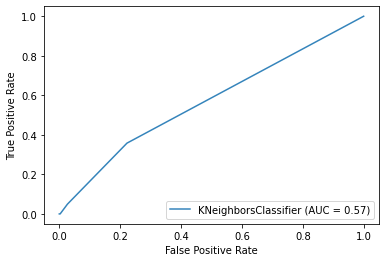

In [7]:
clf_comp(post_enc_df)

# Selecting the important features for the dataset

I will use the Embedded method and then Chi-squared to select features in the dataset in order to narrow down my search.

In [8]:
# Separating out the features
X =  new_df.drop('Target', axis=1) #df_td.drop('Target', axis=1)# train_feat
# Separating out the target
y = new_df.Target #df_td.Target#target_feat

## Using LassoCV

In [9]:
#First I am using the Embedded method to narrow down my search. 
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

reg = LassoCV(max_iter = 10000, tol=0.00001)
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.004858
Best score using built-in LassoCV: 0.127922


In [10]:
LassoCV().get_params().keys()

dict_keys(['alphas', 'copy_X', 'cv', 'eps', 'fit_intercept', 'max_iter', 'n_alphas', 'n_jobs', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'verbose'])

In [11]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 29 variables and eliminated the other 109 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

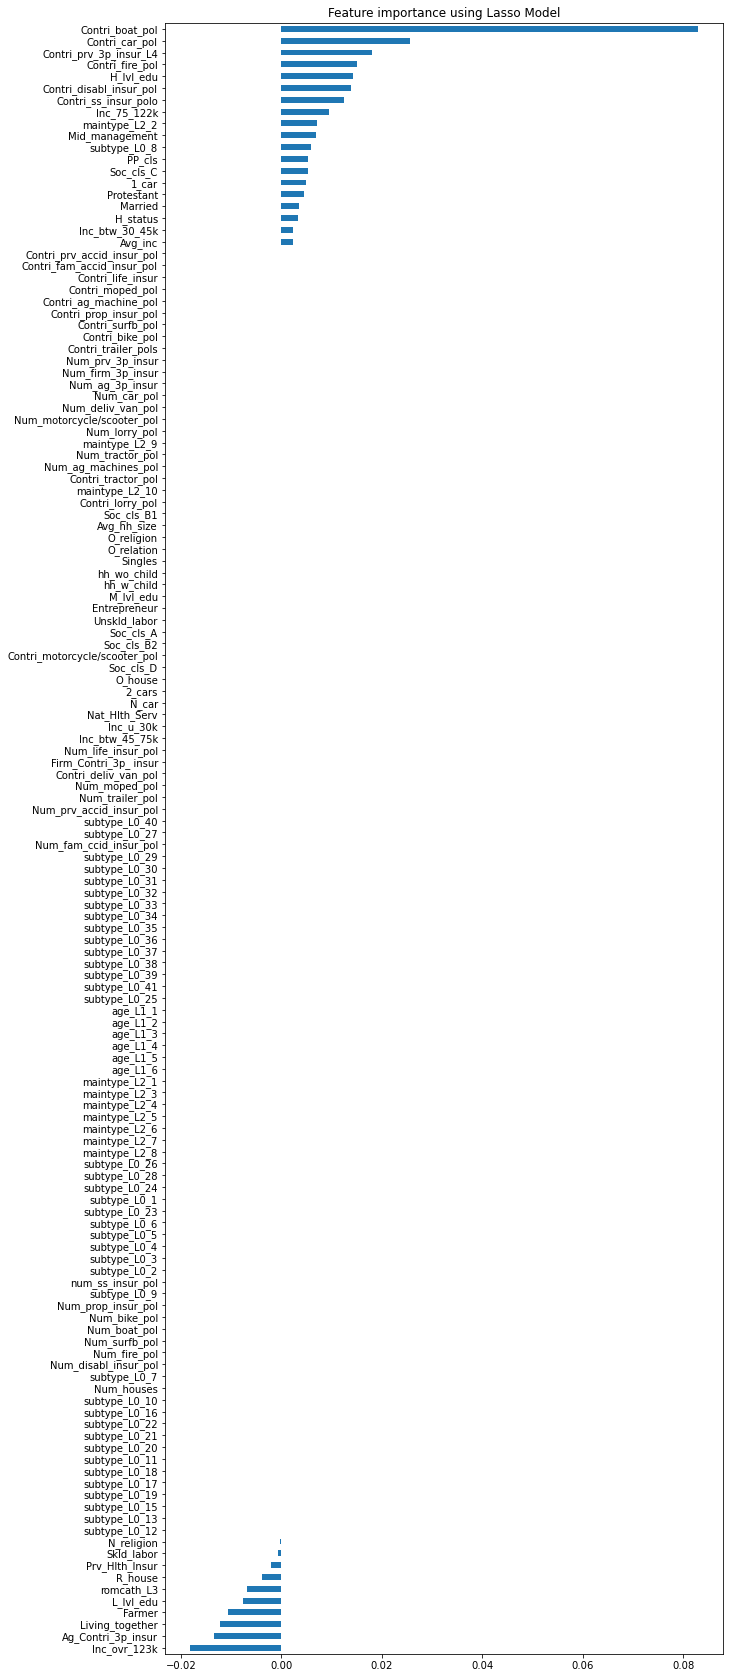

In [16]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 30)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [12]:
coef

Num_houses       -0.000000
Avg_hh_size      -0.000000
romcath_L3       -0.006852
Protestant        0.004609
O_religion        0.000000
                    ...   
maintype_L2_6    -0.000000
maintype_L2_7     0.000000
maintype_L2_8     0.000000
maintype_L2_9     0.000000
maintype_L2_10   -0.000000
Length: 138, dtype: float64

In [13]:
lasso_col = new_df[['romcath_L3','Protestant','O_religion','N_religion','Married','Living_together','H_lvl_edu','L_lvl_edu','Farmer','Mid_management',
                        'Skld_labor','Soc_cls_B1','Soc_cls_C','R_house','1_car','Prv_Hlth_Insur','Inc_btw_30_45k','Inc_75_122k',
                       'Inc_ovr_123k','Avg_inc','PP_cls','Contri_prv_3p_insur_L4','Ag_Contri_3p_insur','Ag_Contri_3p_insur','Contri_car_pol',          
                'Contri_tractor_pol','Contri_disabl_insur_pol','Contri_fire_pol','Contri_boat_pol','Contri_ss_insur_polo',
                       'subtype_L0_8', 'Target']]

In [22]:
print(coef)

Num_houses                      -0.000000
Avg_hh_size                     -0.000000
romcath_L3                      -0.006852
Protestant                       0.004609
O_religion                       0.000000
N_religion                      -0.000264
Married                          0.003575
Living_together                 -0.012174
O_relation                      -0.000000
Singles                         -0.000000
hh_wo_child                     -0.000000
hh_w_child                       0.000000
H_lvl_edu                        0.014314
M_lvl_edu                       -0.000000
L_lvl_edu                       -0.007693
H_status                         0.003297
Entrepreneur                     0.000000
Farmer                          -0.010545
Mid_management                   0.006899
Skld_labor                      -0.000749
Unskld_labor                     0.000000
Soc_cls_A                        0.000000
Soc_cls_B1                      -0.000000
Soc_cls_B2                       0

KNeighborsClassifier(n_neighbors=3)
The Training F1 Score is 0.5341880341880342
The Testing F1 Score is 0.13157894736842105
accuracy score
 0.8421052631578947
balanced_accuracy_score
 0.5263035381750465
model confusion matrix
 [[0.83014354 0.02631579]
 [0.13157895 0.01196172]]
classification_report
               precision    recall  f1-score   support

           0       0.86      0.97      0.91       358
           1       0.31      0.08      0.13        60

    accuracy                           0.84       418
   macro avg       0.59      0.53      0.52       418
weighted avg       0.78      0.84      0.80       418
 

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
The Training F1 Score is 0.24277456647398843
The Testing F1 Score is 0.31481481481481477
accuracy score
 0.4688995215311005
balanced_accuracy_score
 0.6275139664804469
model confusion matrix
 [[0.34688995 0.50956938]
 [0.0215311  0.12200957]]
classification_report
               precision    recall  f1-score

C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GradientBoostingClassifier()
The Training F1 Score is 0.4711779448621554
The Testing F1 Score is 0.1531914893617021
accuracy score
 0.5239234449760766
balanced_accuracy_score
 0.4307262569832402
model confusion matrix
 [[0.48086124 0.37559809]
 [0.10047847 0.0430622 ]]
classification_report
               precision    recall  f1-score   support

           0       0.83      0.56      0.67       358
           1       0.10      0.30      0.15        60

    accuracy                           0.52       418
   macro avg       0.47      0.43      0.41       418
weighted avg       0.72      0.52      0.59       418
 



C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
The Training F1 Score is 0.7662835249042146
The Testing F1 Score is 0.0
accuracy score
 0.8373205741626795
balanced_accuracy_score
 0.4888268156424581
model confusion matrix
 [[0.83732057 0.01913876]
 [0.14354067 0.        ]]
classification_report
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       358
           1       0.00      0.00      0.00        60

    accuracy                           0.84       418
   macro avg       0.43      0.49      0.46       418
weighted avg       0.73      0.84      0.78       418
 

GaussianNB()
The Training F1 Score is 0.416
The Testing F1 Score is 0.08888888888888888
accuracy score
 0.8038277511961722
balanced_accuracy_score
 0.49702048417132216
model confusion matrix
 [[0.79425837 0.06220096]
 [0.13397129 0.00956938]]
classification_report
               precision    recall  f1-score   support

           0       0.86      0.93      

C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Threadripper\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\discriminant_analysis.py:715: 

               precision    recall  f1-score   support

           0       0.86      1.00      0.92       358
           1       0.00      0.00      0.00        60

    accuracy                           0.86       418
   macro avg       0.43      0.50      0.46       418
weighted avg       0.73      0.86      0.79       418
 



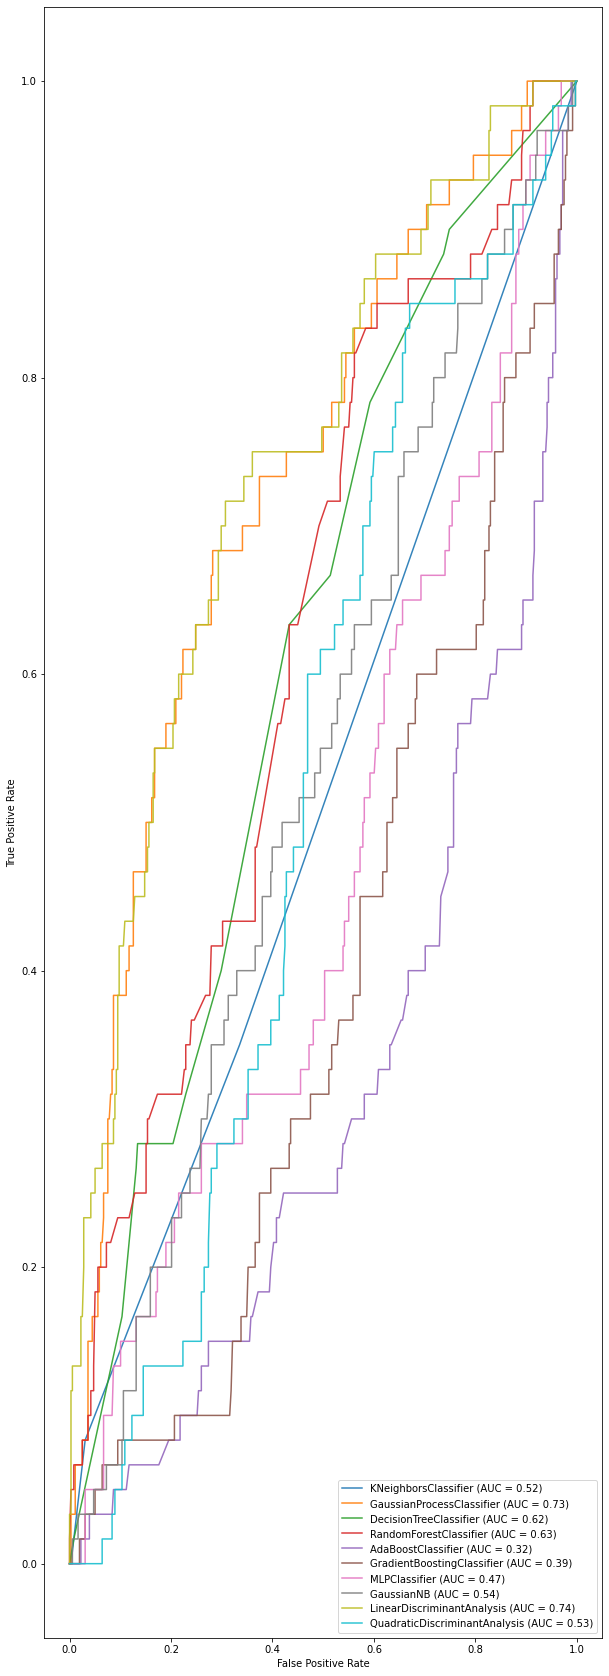

In [20]:
clf_comp(lasso_col)

## Using Chi-squared

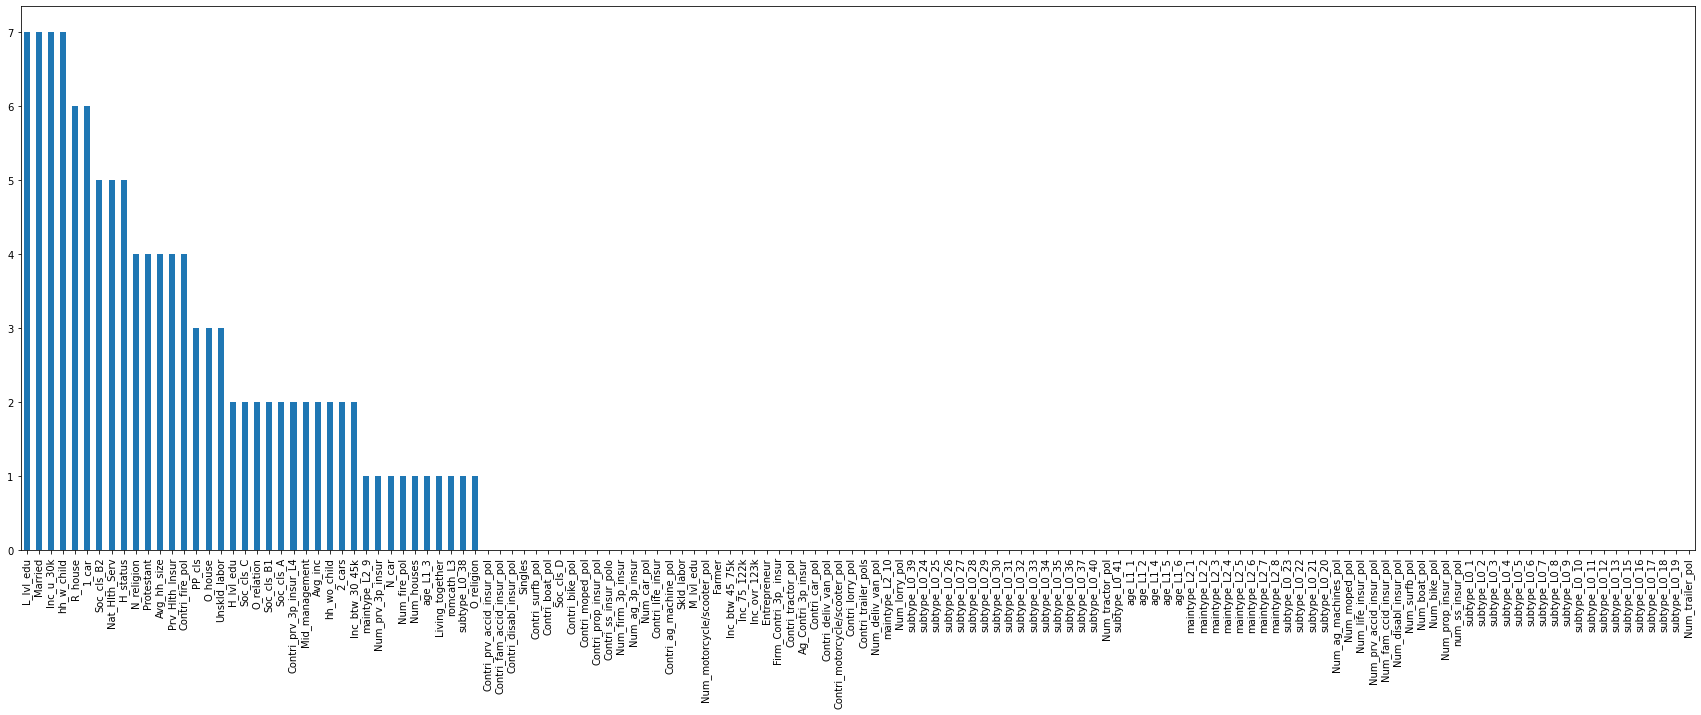

In [23]:
#Now using the Chi-Squared method
from sklearn.feature_selection import chi2, SelectKBest


chi_scores = SelectKBest(chi2, k="all").fit_transform(X, y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
plt.rcParams['figure.figsize'] = (30, 10)
p_values.plot.bar()

In [21]:
pd.set_option('display.max_rows', None)  # or 1000
p_values

subtype_L0_7                     1.000000e+00
romcath_L3                       9.908023e-01
age_L1_2                         9.843682e-01
maintype_L2_9                    9.548889e-01
subtype_L0_2                     9.397430e-01
subtype_L0_39                    9.338154e-01
age_L1_4                         9.276393e-01
age_L1_5                         9.148647e-01
O_religion                       9.100412e-01
Inc_btw_30_45k                   9.006522e-01
Contri_prop_insur_pol            8.927384e-01
subtype_L0_38                    8.771891e-01
subtype_L0_32                    8.509807e-01
Soc_cls_B2                       7.921915e-01
Num_houses                       7.875073e-01
subtype_L0_11                    7.709662e-01
age_L1_6                         7.518296e-01
age_L1_3                         7.328666e-01
subtype_L0_5                     7.290345e-01
subtype_L0_34                    7.290345e-01
Num_firm_3p_insur                7.257210e-01
2_cars                           7

In [25]:
X_df = post_enc_df.drop('Target', axis=1)
y_df = post_enc_df.Target

In [26]:
X_df.shape

(5822, 138)

In [28]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA



# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=138)

# Maybe some original features where good, too?
selection = SelectKBest(k=137)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X_df, y_df).transform(X_df)
print("Combined space has", X_features.shape[1], "features")

gbc = GradientBoostingClassifier()

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("gbc", gbc)])

param_grid = dict(features__pca__n_components=[1, 2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89],
                  features__univ_select__k=[1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88],)

grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose=10)
grid_search.fit(X_df, y_df)
print(grid_search.best_estimator_)

Combined space has 275 features
Fitting 5 folds for each of 7832 candidates, totalling 39160 fits
[CV] features__pca__n_components=1, features__univ_select__k=1 .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  features__pca__n_components=1, features__univ_select__k=1, score=0.939, total=   0.4s
[CV] features__pca__n_components=1, features__univ_select__k=1 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=1, score=0.936, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=1 .......


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=1, score=0.940, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=1 .......


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=1, score=0.936, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=1 .......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=1, score=0.936, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=2 .......


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=2, score=0.937, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=2 .......


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.9s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=2, score=0.936, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=2 .......


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    2.2s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=2, score=0.938, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=2 .......


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=2, score=0.940, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=2 .......


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.8s remaining:    0.0s


[CV]  features__pca__n_components=1, features__univ_select__k=2, score=0.936, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=3 .......
[CV]  features__pca__n_components=1, features__univ_select__k=3, score=0.940, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=3 .......
[CV]  features__pca__n_components=1, features__univ_select__k=3, score=0.936, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=3 .......
[CV]  features__pca__n_components=1, features__univ_select__k=3, score=0.937, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=3 .......
[CV]  features__pca__n_components=1, features__univ_select__k=3, score=0.939, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=3 .......
[CV]  features__pca__n_components=1, features__univ_select__k=3, score=0.939, total=   0.3s
[CV] features__pca__n_components=1, features__univ_select__k=4 .......
[CV]  features__pca__n

[CV]  features__pca__n_components=1, features__univ_select__k=13, score=0.937, total=   0.5s
[CV] features__pca__n_components=1, features__univ_select__k=13 ......
[CV]  features__pca__n_components=1, features__univ_select__k=13, score=0.935, total=   0.6s
[CV] features__pca__n_components=1, features__univ_select__k=13 ......
[CV]  features__pca__n_components=1, features__univ_select__k=13, score=0.940, total=   0.8s
[CV] features__pca__n_components=1, features__univ_select__k=13 ......
[CV]  features__pca__n_components=1, features__univ_select__k=13, score=0.939, total=   0.6s
[CV] features__pca__n_components=1, features__univ_select__k=13 ......
[CV]  features__pca__n_components=1, features__univ_select__k=13, score=0.942, total=   0.6s
[CV] features__pca__n_components=1, features__univ_select__k=14 ......
[CV]  features__pca__n_components=1, features__univ_select__k=14, score=0.941, total=   0.5s
[CV] features__pca__n_components=1, features__univ_select__k=14 ......
[CV]  features__

[CV]  features__pca__n_components=1, features__univ_select__k=23, score=0.939, total=   1.0s
[CV] features__pca__n_components=1, features__univ_select__k=23 ......
[CV]  features__pca__n_components=1, features__univ_select__k=23, score=0.935, total=   1.0s
[CV] features__pca__n_components=1, features__univ_select__k=23 ......
[CV]  features__pca__n_components=1, features__univ_select__k=23, score=0.938, total=   1.0s
[CV] features__pca__n_components=1, features__univ_select__k=23 ......
[CV]  features__pca__n_components=1, features__univ_select__k=23, score=0.938, total=   0.8s
[CV] features__pca__n_components=1, features__univ_select__k=23 ......
[CV]  features__pca__n_components=1, features__univ_select__k=23, score=0.936, total=   0.7s
[CV] features__pca__n_components=1, features__univ_select__k=24 ......
[CV]  features__pca__n_components=1, features__univ_select__k=24, score=0.939, total=   0.7s
[CV] features__pca__n_components=1, features__univ_select__k=24 ......
[CV]  features__

[CV]  features__pca__n_components=1, features__univ_select__k=33, score=0.937, total=   0.8s
[CV] features__pca__n_components=1, features__univ_select__k=33 ......
[CV]  features__pca__n_components=1, features__univ_select__k=33, score=0.936, total=   0.8s
[CV] features__pca__n_components=1, features__univ_select__k=33 ......
[CV]  features__pca__n_components=1, features__univ_select__k=33, score=0.936, total=   0.8s
[CV] features__pca__n_components=1, features__univ_select__k=33 ......
[CV]  features__pca__n_components=1, features__univ_select__k=33, score=0.938, total=   0.8s
[CV] features__pca__n_components=1, features__univ_select__k=33 ......
[CV]  features__pca__n_components=1, features__univ_select__k=33, score=0.939, total=   0.8s
[CV] features__pca__n_components=1, features__univ_select__k=34 ......
[CV]  features__pca__n_components=1, features__univ_select__k=34, score=0.935, total=   0.9s
[CV] features__pca__n_components=1, features__univ_select__k=34 ......
[CV]  features__

[CV]  features__pca__n_components=1, features__univ_select__k=43, score=0.937, total=   1.0s
[CV] features__pca__n_components=1, features__univ_select__k=43 ......
[CV]  features__pca__n_components=1, features__univ_select__k=43, score=0.932, total=   0.9s
[CV] features__pca__n_components=1, features__univ_select__k=43 ......
[CV]  features__pca__n_components=1, features__univ_select__k=43, score=0.939, total=   0.9s
[CV] features__pca__n_components=1, features__univ_select__k=43 ......
[CV]  features__pca__n_components=1, features__univ_select__k=43, score=0.939, total=   1.0s
[CV] features__pca__n_components=1, features__univ_select__k=43 ......
[CV]  features__pca__n_components=1, features__univ_select__k=43, score=0.936, total=   1.0s
[CV] features__pca__n_components=1, features__univ_select__k=44 ......
[CV]  features__pca__n_components=1, features__univ_select__k=44, score=0.937, total=   1.0s
[CV] features__pca__n_components=1, features__univ_select__k=44 ......
[CV]  features__

[CV]  features__pca__n_components=1, features__univ_select__k=53, score=0.936, total=   1.3s
[CV] features__pca__n_components=1, features__univ_select__k=53 ......
[CV]  features__pca__n_components=1, features__univ_select__k=53, score=0.936, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=53 ......
[CV]  features__pca__n_components=1, features__univ_select__k=53, score=0.939, total=   1.1s
[CV] features__pca__n_components=1, features__univ_select__k=53 ......
[CV]  features__pca__n_components=1, features__univ_select__k=53, score=0.939, total=   1.0s
[CV] features__pca__n_components=1, features__univ_select__k=53 ......
[CV]  features__pca__n_components=1, features__univ_select__k=53, score=0.935, total=   1.1s
[CV] features__pca__n_components=1, features__univ_select__k=54 ......
[CV]  features__pca__n_components=1, features__univ_select__k=54, score=0.936, total=   1.1s
[CV] features__pca__n_components=1, features__univ_select__k=54 ......
[CV]  features__

[CV]  features__pca__n_components=1, features__univ_select__k=63, score=0.937, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=63 ......
[CV]  features__pca__n_components=1, features__univ_select__k=63, score=0.934, total=   1.1s
[CV] features__pca__n_components=1, features__univ_select__k=63 ......
[CV]  features__pca__n_components=1, features__univ_select__k=63, score=0.940, total=   1.1s
[CV] features__pca__n_components=1, features__univ_select__k=63 ......
[CV]  features__pca__n_components=1, features__univ_select__k=63, score=0.940, total=   1.1s
[CV] features__pca__n_components=1, features__univ_select__k=63 ......
[CV]  features__pca__n_components=1, features__univ_select__k=63, score=0.936, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=64 ......
[CV]  features__pca__n_components=1, features__univ_select__k=64, score=0.938, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=64 ......
[CV]  features__

[CV]  features__pca__n_components=1, features__univ_select__k=73, score=0.938, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=73 ......
[CV]  features__pca__n_components=1, features__univ_select__k=73, score=0.931, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=73 ......
[CV]  features__pca__n_components=1, features__univ_select__k=73, score=0.941, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=73 ......
[CV]  features__pca__n_components=1, features__univ_select__k=73, score=0.941, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=73 ......
[CV]  features__pca__n_components=1, features__univ_select__k=73, score=0.936, total=   1.3s
[CV] features__pca__n_components=1, features__univ_select__k=74 ......
[CV]  features__pca__n_components=1, features__univ_select__k=74, score=0.938, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=74 ......
[CV]  features__

[CV]  features__pca__n_components=1, features__univ_select__k=83, score=0.939, total=   1.4s
[CV] features__pca__n_components=1, features__univ_select__k=83 ......
[CV]  features__pca__n_components=1, features__univ_select__k=83, score=0.931, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=83 ......
[CV]  features__pca__n_components=1, features__univ_select__k=83, score=0.941, total=   1.3s
[CV] features__pca__n_components=1, features__univ_select__k=83 ......
[CV]  features__pca__n_components=1, features__univ_select__k=83, score=0.940, total=   1.3s
[CV] features__pca__n_components=1, features__univ_select__k=83 ......
[CV]  features__pca__n_components=1, features__univ_select__k=83, score=0.936, total=   1.2s
[CV] features__pca__n_components=1, features__univ_select__k=84 ......
[CV]  features__pca__n_components=1, features__univ_select__k=84, score=0.939, total=   1.3s
[CV] features__pca__n_components=1, features__univ_select__k=84 ......
[CV]  features__

[CV]  features__pca__n_components=2, features__univ_select__k=5, score=0.938, total=   0.4s
[CV] features__pca__n_components=2, features__univ_select__k=5 .......
[CV]  features__pca__n_components=2, features__univ_select__k=5, score=0.939, total=   0.5s
[CV] features__pca__n_components=2, features__univ_select__k=5 .......
[CV]  features__pca__n_components=2, features__univ_select__k=5, score=0.937, total=   0.4s
[CV] features__pca__n_components=2, features__univ_select__k=5 .......
[CV]  features__pca__n_components=2, features__univ_select__k=5, score=0.936, total=   0.4s
[CV] features__pca__n_components=2, features__univ_select__k=6 .......
[CV]  features__pca__n_components=2, features__univ_select__k=6, score=0.937, total=   0.5s
[CV] features__pca__n_components=2, features__univ_select__k=6 .......
[CV]  features__pca__n_components=2, features__univ_select__k=6, score=0.935, total=   0.5s
[CV] features__pca__n_components=2, features__univ_select__k=6 .......
[CV]  features__pca__n

[CV]  features__pca__n_components=2, features__univ_select__k=15, score=0.942, total=   0.6s
[CV] features__pca__n_components=2, features__univ_select__k=15 ......
[CV]  features__pca__n_components=2, features__univ_select__k=15, score=0.936, total=   0.6s
[CV] features__pca__n_components=2, features__univ_select__k=15 ......
[CV]  features__pca__n_components=2, features__univ_select__k=15, score=0.935, total=   0.6s
[CV] features__pca__n_components=2, features__univ_select__k=16 ......
[CV]  features__pca__n_components=2, features__univ_select__k=16, score=0.937, total=   0.7s
[CV] features__pca__n_components=2, features__univ_select__k=16 ......
[CV]  features__pca__n_components=2, features__univ_select__k=16, score=0.936, total=   0.6s
[CV] features__pca__n_components=2, features__univ_select__k=16 ......
[CV]  features__pca__n_components=2, features__univ_select__k=16, score=0.942, total=   0.6s
[CV] features__pca__n_components=2, features__univ_select__k=16 ......
[CV]  features__

[CV]  features__pca__n_components=2, features__univ_select__k=25, score=0.938, total=   0.8s
[CV] features__pca__n_components=2, features__univ_select__k=25 ......
[CV]  features__pca__n_components=2, features__univ_select__k=25, score=0.938, total=   0.8s
[CV] features__pca__n_components=2, features__univ_select__k=25 ......
[CV]  features__pca__n_components=2, features__univ_select__k=25, score=0.938, total=   0.8s
[CV] features__pca__n_components=2, features__univ_select__k=26 ......
[CV]  features__pca__n_components=2, features__univ_select__k=26, score=0.937, total=   0.8s
[CV] features__pca__n_components=2, features__univ_select__k=26 ......
[CV]  features__pca__n_components=2, features__univ_select__k=26, score=0.934, total=   0.8s
[CV] features__pca__n_components=2, features__univ_select__k=26 ......
[CV]  features__pca__n_components=2, features__univ_select__k=26, score=0.938, total=   0.9s
[CV] features__pca__n_components=2, features__univ_select__k=26 ......
[CV]  features__

[CV]  features__pca__n_components=2, features__univ_select__k=35, score=0.940, total=   1.0s
[CV] features__pca__n_components=2, features__univ_select__k=35 ......
[CV]  features__pca__n_components=2, features__univ_select__k=35, score=0.938, total=   1.0s
[CV] features__pca__n_components=2, features__univ_select__k=35 ......
[CV]  features__pca__n_components=2, features__univ_select__k=35, score=0.936, total=   1.0s
[CV] features__pca__n_components=2, features__univ_select__k=36 ......
[CV]  features__pca__n_components=2, features__univ_select__k=36, score=0.936, total=   1.1s
[CV] features__pca__n_components=2, features__univ_select__k=36 ......
[CV]  features__pca__n_components=2, features__univ_select__k=36, score=0.936, total=   1.0s
[CV] features__pca__n_components=2, features__univ_select__k=36 ......
[CV]  features__pca__n_components=2, features__univ_select__k=36, score=0.938, total=   1.0s
[CV] features__pca__n_components=2, features__univ_select__k=36 ......
[CV]  features__

[CV]  features__pca__n_components=2, features__univ_select__k=45, score=0.942, total=   1.1s
[CV] features__pca__n_components=2, features__univ_select__k=45 ......
[CV]  features__pca__n_components=2, features__univ_select__k=45, score=0.937, total=   1.2s
[CV] features__pca__n_components=2, features__univ_select__k=45 ......
[CV]  features__pca__n_components=2, features__univ_select__k=45, score=0.936, total=   1.2s
[CV] features__pca__n_components=2, features__univ_select__k=46 ......
[CV]  features__pca__n_components=2, features__univ_select__k=46, score=0.936, total=   1.3s
[CV] features__pca__n_components=2, features__univ_select__k=46 ......
[CV]  features__pca__n_components=2, features__univ_select__k=46, score=0.930, total=   1.2s
[CV] features__pca__n_components=2, features__univ_select__k=46 ......
[CV]  features__pca__n_components=2, features__univ_select__k=46, score=0.941, total=   1.1s
[CV] features__pca__n_components=2, features__univ_select__k=46 ......
[CV]  features__

[CV]  features__pca__n_components=2, features__univ_select__k=55, score=0.939, total=   1.3s
[CV] features__pca__n_components=2, features__univ_select__k=55 ......
[CV]  features__pca__n_components=2, features__univ_select__k=55, score=0.936, total=   1.3s
[CV] features__pca__n_components=2, features__univ_select__k=55 ......
[CV]  features__pca__n_components=2, features__univ_select__k=55, score=0.934, total=   1.3s
[CV] features__pca__n_components=2, features__univ_select__k=56 ......
[CV]  features__pca__n_components=2, features__univ_select__k=56, score=0.936, total=   1.3s
[CV] features__pca__n_components=2, features__univ_select__k=56 ......
[CV]  features__pca__n_components=2, features__univ_select__k=56, score=0.935, total=   1.3s
[CV] features__pca__n_components=2, features__univ_select__k=56 ......
[CV]  features__pca__n_components=2, features__univ_select__k=56, score=0.939, total=   1.3s
[CV] features__pca__n_components=2, features__univ_select__k=56 ......
[CV]  features__

[CV]  features__pca__n_components=2, features__univ_select__k=65, score=0.940, total=   1.4s
[CV] features__pca__n_components=2, features__univ_select__k=65 ......
[CV]  features__pca__n_components=2, features__univ_select__k=65, score=0.936, total=   1.4s
[CV] features__pca__n_components=2, features__univ_select__k=65 ......
[CV]  features__pca__n_components=2, features__univ_select__k=65, score=0.936, total=   1.4s
[CV] features__pca__n_components=2, features__univ_select__k=66 ......
[CV]  features__pca__n_components=2, features__univ_select__k=66, score=0.937, total=   1.4s
[CV] features__pca__n_components=2, features__univ_select__k=66 ......
[CV]  features__pca__n_components=2, features__univ_select__k=66, score=0.930, total=   1.4s
[CV] features__pca__n_components=2, features__univ_select__k=66 ......
[CV]  features__pca__n_components=2, features__univ_select__k=66, score=0.942, total=   1.3s
[CV] features__pca__n_components=2, features__univ_select__k=66 ......
[CV]  features__

[CV]  features__pca__n_components=2, features__univ_select__k=75, score=0.942, total=   1.4s
[CV] features__pca__n_components=2, features__univ_select__k=75 ......
[CV]  features__pca__n_components=2, features__univ_select__k=75, score=0.939, total=   1.4s
[CV] features__pca__n_components=2, features__univ_select__k=75 ......
[CV]  features__pca__n_components=2, features__univ_select__k=75, score=0.937, total=   1.4s
[CV] features__pca__n_components=2, features__univ_select__k=76 ......
[CV]  features__pca__n_components=2, features__univ_select__k=76, score=0.937, total=   1.5s
[CV] features__pca__n_components=2, features__univ_select__k=76 ......
[CV]  features__pca__n_components=2, features__univ_select__k=76, score=0.933, total=   1.5s
[CV] features__pca__n_components=2, features__univ_select__k=76 ......
[CV]  features__pca__n_components=2, features__univ_select__k=76, score=0.941, total=   1.4s
[CV] features__pca__n_components=2, features__univ_select__k=76 ......
[CV]  features__

[CV]  features__pca__n_components=2, features__univ_select__k=85, score=0.942, total=   1.5s
[CV] features__pca__n_components=2, features__univ_select__k=85 ......
[CV]  features__pca__n_components=2, features__univ_select__k=85, score=0.935, total=   1.5s
[CV] features__pca__n_components=2, features__univ_select__k=85 ......
[CV]  features__pca__n_components=2, features__univ_select__k=85, score=0.937, total=   1.5s
[CV] features__pca__n_components=2, features__univ_select__k=86 ......
[CV]  features__pca__n_components=2, features__univ_select__k=86, score=0.938, total=   1.6s
[CV] features__pca__n_components=2, features__univ_select__k=86 ......
[CV]  features__pca__n_components=2, features__univ_select__k=86, score=0.935, total=   1.5s
[CV] features__pca__n_components=2, features__univ_select__k=86 ......
[CV]  features__pca__n_components=2, features__univ_select__k=86, score=0.942, total=   1.5s
[CV] features__pca__n_components=2, features__univ_select__k=86 ......
[CV]  features__

[CV]  features__pca__n_components=3, features__univ_select__k=7, score=0.939, total=   0.6s
[CV] features__pca__n_components=3, features__univ_select__k=7 .......
[CV]  features__pca__n_components=3, features__univ_select__k=7, score=0.936, total=   0.6s
[CV] features__pca__n_components=3, features__univ_select__k=8 .......
[CV]  features__pca__n_components=3, features__univ_select__k=8, score=0.936, total=   0.6s
[CV] features__pca__n_components=3, features__univ_select__k=8 .......
[CV]  features__pca__n_components=3, features__univ_select__k=8, score=0.936, total=   0.6s
[CV] features__pca__n_components=3, features__univ_select__k=8 .......
[CV]  features__pca__n_components=3, features__univ_select__k=8, score=0.941, total=   0.6s
[CV] features__pca__n_components=3, features__univ_select__k=8 .......
[CV]  features__pca__n_components=3, features__univ_select__k=8, score=0.937, total=   0.6s
[CV] features__pca__n_components=3, features__univ_select__k=8 .......
[CV]  features__pca__n

[CV]  features__pca__n_components=3, features__univ_select__k=17, score=0.938, total=   0.8s
[CV] features__pca__n_components=3, features__univ_select__k=18 ......
[CV]  features__pca__n_components=3, features__univ_select__k=18, score=0.936, total=   0.8s
[CV] features__pca__n_components=3, features__univ_select__k=18 ......
[CV]  features__pca__n_components=3, features__univ_select__k=18, score=0.939, total=   0.8s
[CV] features__pca__n_components=3, features__univ_select__k=18 ......
[CV]  features__pca__n_components=3, features__univ_select__k=18, score=0.940, total=   0.8s
[CV] features__pca__n_components=3, features__univ_select__k=18 ......
[CV]  features__pca__n_components=3, features__univ_select__k=18, score=0.935, total=   0.8s
[CV] features__pca__n_components=3, features__univ_select__k=18 ......
[CV]  features__pca__n_components=3, features__univ_select__k=18, score=0.936, total=   0.8s
[CV] features__pca__n_components=3, features__univ_select__k=19 ......
[CV]  features__

[CV]  features__pca__n_components=3, features__univ_select__k=27, score=0.937, total=   1.0s
[CV] features__pca__n_components=3, features__univ_select__k=28 ......
[CV]  features__pca__n_components=3, features__univ_select__k=28, score=0.937, total=   1.0s
[CV] features__pca__n_components=3, features__univ_select__k=28 ......
[CV]  features__pca__n_components=3, features__univ_select__k=28, score=0.936, total=   1.0s
[CV] features__pca__n_components=3, features__univ_select__k=28 ......
[CV]  features__pca__n_components=3, features__univ_select__k=28, score=0.938, total=   1.0s
[CV] features__pca__n_components=3, features__univ_select__k=28 ......
[CV]  features__pca__n_components=3, features__univ_select__k=28, score=0.936, total=   1.0s
[CV] features__pca__n_components=3, features__univ_select__k=28 ......
[CV]  features__pca__n_components=3, features__univ_select__k=28, score=0.936, total=   1.0s
[CV] features__pca__n_components=3, features__univ_select__k=29 ......
[CV]  features__

[CV]  features__pca__n_components=3, features__univ_select__k=37, score=0.938, total=   1.5s
[CV] features__pca__n_components=3, features__univ_select__k=38 ......
[CV]  features__pca__n_components=3, features__univ_select__k=38, score=0.936, total=   1.6s
[CV] features__pca__n_components=3, features__univ_select__k=38 ......
[CV]  features__pca__n_components=3, features__univ_select__k=38, score=0.935, total=   1.5s
[CV] features__pca__n_components=3, features__univ_select__k=38 ......
[CV]  features__pca__n_components=3, features__univ_select__k=38, score=0.939, total=   1.3s
[CV] features__pca__n_components=3, features__univ_select__k=38 ......
[CV]  features__pca__n_components=3, features__univ_select__k=38, score=0.936, total=   1.2s
[CV] features__pca__n_components=3, features__univ_select__k=38 ......
[CV]  features__pca__n_components=3, features__univ_select__k=38, score=0.937, total=   1.2s
[CV] features__pca__n_components=3, features__univ_select__k=39 ......
[CV]  features__

[CV]  features__pca__n_components=3, features__univ_select__k=47, score=0.938, total=   1.3s
[CV] features__pca__n_components=3, features__univ_select__k=48 ......
[CV]  features__pca__n_components=3, features__univ_select__k=48, score=0.936, total=   1.3s
[CV] features__pca__n_components=3, features__univ_select__k=48 ......
[CV]  features__pca__n_components=3, features__univ_select__k=48, score=0.936, total=   1.3s
[CV] features__pca__n_components=3, features__univ_select__k=48 ......
[CV]  features__pca__n_components=3, features__univ_select__k=48, score=0.938, total=   1.3s
[CV] features__pca__n_components=3, features__univ_select__k=48 ......
[CV]  features__pca__n_components=3, features__univ_select__k=48, score=0.937, total=   1.3s
[CV] features__pca__n_components=3, features__univ_select__k=48 ......
[CV]  features__pca__n_components=3, features__univ_select__k=48, score=0.936, total=   1.3s
[CV] features__pca__n_components=3, features__univ_select__k=49 ......
[CV]  features__

[CV]  features__pca__n_components=3, features__univ_select__k=57, score=0.935, total=   1.6s
[CV] features__pca__n_components=3, features__univ_select__k=58 ......
[CV]  features__pca__n_components=3, features__univ_select__k=58, score=0.938, total=   1.7s
[CV] features__pca__n_components=3, features__univ_select__k=58 ......
[CV]  features__pca__n_components=3, features__univ_select__k=58, score=0.936, total=   1.8s
[CV] features__pca__n_components=3, features__univ_select__k=58 ......
[CV]  features__pca__n_components=3, features__univ_select__k=58, score=0.937, total=   1.5s
[CV] features__pca__n_components=3, features__univ_select__k=58 ......
[CV]  features__pca__n_components=3, features__univ_select__k=58, score=0.936, total=   1.4s
[CV] features__pca__n_components=3, features__univ_select__k=58 ......
[CV]  features__pca__n_components=3, features__univ_select__k=58, score=0.936, total=   1.4s
[CV] features__pca__n_components=3, features__univ_select__k=59 ......
[CV]  features__

[CV]  features__pca__n_components=3, features__univ_select__k=67, score=0.936, total=   1.7s
[CV] features__pca__n_components=3, features__univ_select__k=68 ......
[CV]  features__pca__n_components=3, features__univ_select__k=68, score=0.936, total=   2.0s
[CV] features__pca__n_components=3, features__univ_select__k=68 ......
[CV]  features__pca__n_components=3, features__univ_select__k=68, score=0.933, total=   2.3s
[CV] features__pca__n_components=3, features__univ_select__k=68 ......
[CV]  features__pca__n_components=3, features__univ_select__k=68, score=0.939, total=   2.7s
[CV] features__pca__n_components=3, features__univ_select__k=68 ......
[CV]  features__pca__n_components=3, features__univ_select__k=68, score=0.939, total=   2.0s
[CV] features__pca__n_components=3, features__univ_select__k=68 ......
[CV]  features__pca__n_components=3, features__univ_select__k=68, score=0.937, total=   1.8s
[CV] features__pca__n_components=3, features__univ_select__k=69 ......
[CV]  features__

[CV]  features__pca__n_components=3, features__univ_select__k=77, score=0.936, total=   1.5s
[CV] features__pca__n_components=3, features__univ_select__k=78 ......
[CV]  features__pca__n_components=3, features__univ_select__k=78, score=0.938, total=   1.6s
[CV] features__pca__n_components=3, features__univ_select__k=78 ......
[CV]  features__pca__n_components=3, features__univ_select__k=78, score=0.936, total=   1.6s
[CV] features__pca__n_components=3, features__univ_select__k=78 ......
[CV]  features__pca__n_components=3, features__univ_select__k=78, score=0.942, total=   1.8s
[CV] features__pca__n_components=3, features__univ_select__k=78 ......
[CV]  features__pca__n_components=3, features__univ_select__k=78, score=0.937, total=   1.7s
[CV] features__pca__n_components=3, features__univ_select__k=78 ......
[CV]  features__pca__n_components=3, features__univ_select__k=78, score=0.938, total=   1.8s
[CV] features__pca__n_components=3, features__univ_select__k=79 ......
[CV]  features__

[CV]  features__pca__n_components=3, features__univ_select__k=87, score=0.938, total=   1.6s
[CV] features__pca__n_components=3, features__univ_select__k=88 ......
[CV]  features__pca__n_components=3, features__univ_select__k=88, score=0.936, total=   1.6s
[CV] features__pca__n_components=3, features__univ_select__k=88 ......
[CV]  features__pca__n_components=3, features__univ_select__k=88, score=0.936, total=   1.6s
[CV] features__pca__n_components=3, features__univ_select__k=88 ......
[CV]  features__pca__n_components=3, features__univ_select__k=88, score=0.941, total=   1.6s
[CV] features__pca__n_components=3, features__univ_select__k=88 ......
[CV]  features__pca__n_components=3, features__univ_select__k=88, score=0.937, total=   1.6s
[CV] features__pca__n_components=3, features__univ_select__k=88 ......
[CV]  features__pca__n_components=3, features__univ_select__k=88, score=0.938, total=   1.6s
[CV] features__pca__n_components=4, features__univ_select__k=1 .......
[CV]  features__

[CV]  features__pca__n_components=4, features__univ_select__k=10, score=0.936, total=   0.8s
[CV] features__pca__n_components=4, features__univ_select__k=10 ......
[CV]  features__pca__n_components=4, features__univ_select__k=10, score=0.936, total=   0.8s
[CV] features__pca__n_components=4, features__univ_select__k=10 ......
[CV]  features__pca__n_components=4, features__univ_select__k=10, score=0.941, total=   0.7s
[CV] features__pca__n_components=4, features__univ_select__k=10 ......
[CV]  features__pca__n_components=4, features__univ_select__k=10, score=0.936, total=   0.7s
[CV] features__pca__n_components=4, features__univ_select__k=10 ......
[CV]  features__pca__n_components=4, features__univ_select__k=10, score=0.936, total=   0.8s
[CV] features__pca__n_components=4, features__univ_select__k=11 ......
[CV]  features__pca__n_components=4, features__univ_select__k=11, score=0.938, total=   0.8s
[CV] features__pca__n_components=4, features__univ_select__k=11 ......
[CV]  features__

[CV]  features__pca__n_components=4, features__univ_select__k=20, score=0.937, total=   1.1s
[CV] features__pca__n_components=4, features__univ_select__k=20 ......
[CV]  features__pca__n_components=4, features__univ_select__k=20, score=0.935, total=   1.2s
[CV] features__pca__n_components=4, features__univ_select__k=20 ......
[CV]  features__pca__n_components=4, features__univ_select__k=20, score=0.937, total=   1.1s
[CV] features__pca__n_components=4, features__univ_select__k=20 ......
[CV]  features__pca__n_components=4, features__univ_select__k=20, score=0.935, total=   1.1s
[CV] features__pca__n_components=4, features__univ_select__k=20 ......
[CV]  features__pca__n_components=4, features__univ_select__k=20, score=0.938, total=   1.1s
[CV] features__pca__n_components=4, features__univ_select__k=21 ......
[CV]  features__pca__n_components=4, features__univ_select__k=21, score=0.939, total=   1.0s
[CV] features__pca__n_components=4, features__univ_select__k=21 ......
[CV]  features__

[CV]  features__pca__n_components=4, features__univ_select__k=30, score=0.936, total=   1.2s
[CV] features__pca__n_components=4, features__univ_select__k=30 ......
[CV]  features__pca__n_components=4, features__univ_select__k=30, score=0.936, total=   1.2s
[CV] features__pca__n_components=4, features__univ_select__k=30 ......
[CV]  features__pca__n_components=4, features__univ_select__k=30, score=0.936, total=   1.4s
[CV] features__pca__n_components=4, features__univ_select__k=30 ......
[CV]  features__pca__n_components=4, features__univ_select__k=30, score=0.936, total=   1.3s
[CV] features__pca__n_components=4, features__univ_select__k=30 ......
[CV]  features__pca__n_components=4, features__univ_select__k=30, score=0.937, total=   1.3s
[CV] features__pca__n_components=4, features__univ_select__k=31 ......
[CV]  features__pca__n_components=4, features__univ_select__k=31, score=0.936, total=   1.3s
[CV] features__pca__n_components=4, features__univ_select__k=31 ......
[CV]  features__

[CV]  features__pca__n_components=4, features__univ_select__k=40, score=0.934, total=   1.4s
[CV] features__pca__n_components=4, features__univ_select__k=40 ......
[CV]  features__pca__n_components=4, features__univ_select__k=40, score=0.930, total=   1.3s
[CV] features__pca__n_components=4, features__univ_select__k=40 ......
[CV]  features__pca__n_components=4, features__univ_select__k=40, score=0.936, total=   1.3s
[CV] features__pca__n_components=4, features__univ_select__k=40 ......
[CV]  features__pca__n_components=4, features__univ_select__k=40, score=0.936, total=   1.3s
[CV] features__pca__n_components=4, features__univ_select__k=40 ......
[CV]  features__pca__n_components=4, features__univ_select__k=40, score=0.937, total=   1.3s
[CV] features__pca__n_components=4, features__univ_select__k=41 ......
[CV]  features__pca__n_components=4, features__univ_select__k=41, score=0.936, total=   1.4s
[CV] features__pca__n_components=4, features__univ_select__k=41 ......
[CV]  features__

[CV]  features__pca__n_components=4, features__univ_select__k=50, score=0.936, total=   1.8s
[CV] features__pca__n_components=4, features__univ_select__k=50 ......
[CV]  features__pca__n_components=4, features__univ_select__k=50, score=0.935, total=   2.1s
[CV] features__pca__n_components=4, features__univ_select__k=50 ......
[CV]  features__pca__n_components=4, features__univ_select__k=50, score=0.941, total=   1.9s
[CV] features__pca__n_components=4, features__univ_select__k=50 ......
[CV]  features__pca__n_components=4, features__univ_select__k=50, score=0.937, total=   2.0s
[CV] features__pca__n_components=4, features__univ_select__k=50 ......
[CV]  features__pca__n_components=4, features__univ_select__k=50, score=0.937, total=   1.7s
[CV] features__pca__n_components=4, features__univ_select__k=51 ......
[CV]  features__pca__n_components=4, features__univ_select__k=51, score=0.935, total=   1.5s
[CV] features__pca__n_components=4, features__univ_select__k=51 ......
[CV]  features__

[CV]  features__pca__n_components=4, features__univ_select__k=60, score=0.936, total=   1.5s
[CV] features__pca__n_components=4, features__univ_select__k=60 ......
[CV]  features__pca__n_components=4, features__univ_select__k=60, score=0.933, total=   1.5s
[CV] features__pca__n_components=4, features__univ_select__k=60 ......
[CV]  features__pca__n_components=4, features__univ_select__k=60, score=0.940, total=   1.5s
[CV] features__pca__n_components=4, features__univ_select__k=60 ......
[CV]  features__pca__n_components=4, features__univ_select__k=60, score=0.938, total=   1.6s
[CV] features__pca__n_components=4, features__univ_select__k=60 ......
[CV]  features__pca__n_components=4, features__univ_select__k=60, score=0.938, total=   1.6s
[CV] features__pca__n_components=4, features__univ_select__k=61 ......
[CV]  features__pca__n_components=4, features__univ_select__k=61, score=0.936, total=   1.6s
[CV] features__pca__n_components=4, features__univ_select__k=61 ......
[CV]  features__

[CV]  features__pca__n_components=4, features__univ_select__k=70, score=0.936, total=   1.7s
[CV] features__pca__n_components=4, features__univ_select__k=70 ......
[CV]  features__pca__n_components=4, features__univ_select__k=70, score=0.936, total=   1.6s
[CV] features__pca__n_components=4, features__univ_select__k=70 ......
[CV]  features__pca__n_components=4, features__univ_select__k=70, score=0.940, total=   1.7s
[CV] features__pca__n_components=4, features__univ_select__k=70 ......
[CV]  features__pca__n_components=4, features__univ_select__k=70, score=0.939, total=   1.6s
[CV] features__pca__n_components=4, features__univ_select__k=70 ......
[CV]  features__pca__n_components=4, features__univ_select__k=70, score=0.937, total=   1.6s
[CV] features__pca__n_components=4, features__univ_select__k=71 ......
[CV]  features__pca__n_components=4, features__univ_select__k=71, score=0.936, total=   1.6s
[CV] features__pca__n_components=4, features__univ_select__k=71 ......
[CV]  features__

[CV]  features__pca__n_components=4, features__univ_select__k=80, score=0.937, total=   1.7s
[CV] features__pca__n_components=4, features__univ_select__k=80 ......
[CV]  features__pca__n_components=4, features__univ_select__k=80, score=0.935, total=   1.7s
[CV] features__pca__n_components=4, features__univ_select__k=80 ......
[CV]  features__pca__n_components=4, features__univ_select__k=80, score=0.940, total=   1.7s
[CV] features__pca__n_components=4, features__univ_select__k=80 ......
[CV]  features__pca__n_components=4, features__univ_select__k=80, score=0.939, total=   1.7s
[CV] features__pca__n_components=4, features__univ_select__k=80 ......
[CV]  features__pca__n_components=4, features__univ_select__k=80, score=0.939, total=   1.7s
[CV] features__pca__n_components=4, features__univ_select__k=81 ......
[CV]  features__pca__n_components=4, features__univ_select__k=81, score=0.937, total=   1.7s
[CV] features__pca__n_components=4, features__univ_select__k=81 ......
[CV]  features__

[CV]  features__pca__n_components=5, features__univ_select__k=2, score=0.940, total=   0.8s
[CV] features__pca__n_components=5, features__univ_select__k=2 .......
[CV]  features__pca__n_components=5, features__univ_select__k=2, score=0.936, total=   0.8s
[CV] features__pca__n_components=5, features__univ_select__k=2 .......
[CV]  features__pca__n_components=5, features__univ_select__k=2, score=0.940, total=   0.8s
[CV] features__pca__n_components=5, features__univ_select__k=2 .......
[CV]  features__pca__n_components=5, features__univ_select__k=2, score=0.936, total=   0.7s
[CV] features__pca__n_components=5, features__univ_select__k=2 .......
[CV]  features__pca__n_components=5, features__univ_select__k=2, score=0.940, total=   0.7s
[CV] features__pca__n_components=5, features__univ_select__k=3 .......
[CV]  features__pca__n_components=5, features__univ_select__k=3, score=0.936, total=   0.8s
[CV] features__pca__n_components=5, features__univ_select__k=3 .......
[CV]  features__pca__n

[CV]  features__pca__n_components=5, features__univ_select__k=12, score=0.934, total=   0.9s
[CV] features__pca__n_components=5, features__univ_select__k=12 ......
[CV]  features__pca__n_components=5, features__univ_select__k=12, score=0.941, total=   0.9s
[CV] features__pca__n_components=5, features__univ_select__k=12 ......
[CV]  features__pca__n_components=5, features__univ_select__k=12, score=0.935, total=   0.9s
[CV] features__pca__n_components=5, features__univ_select__k=12 ......
[CV]  features__pca__n_components=5, features__univ_select__k=12, score=0.936, total=   0.9s
[CV] features__pca__n_components=5, features__univ_select__k=13 ......
[CV]  features__pca__n_components=5, features__univ_select__k=13, score=0.937, total=   1.0s
[CV] features__pca__n_components=5, features__univ_select__k=13 ......
[CV]  features__pca__n_components=5, features__univ_select__k=13, score=0.935, total=   0.9s
[CV] features__pca__n_components=5, features__univ_select__k=13 ......
[CV]  features__

[CV]  features__pca__n_components=5, features__univ_select__k=22, score=0.936, total=   1.1s
[CV] features__pca__n_components=5, features__univ_select__k=22 ......
[CV]  features__pca__n_components=5, features__univ_select__k=22, score=0.939, total=   1.1s
[CV] features__pca__n_components=5, features__univ_select__k=22 ......
[CV]  features__pca__n_components=5, features__univ_select__k=22, score=0.936, total=   1.1s
[CV] features__pca__n_components=5, features__univ_select__k=22 ......
[CV]  features__pca__n_components=5, features__univ_select__k=22, score=0.933, total=   1.1s
[CV] features__pca__n_components=5, features__univ_select__k=23 ......
[CV]  features__pca__n_components=5, features__univ_select__k=23, score=0.940, total=   1.2s
[CV] features__pca__n_components=5, features__univ_select__k=23 ......
[CV]  features__pca__n_components=5, features__univ_select__k=23, score=0.935, total=   1.1s
[CV] features__pca__n_components=5, features__univ_select__k=23 ......
[CV]  features__

[CV]  features__pca__n_components=5, features__univ_select__k=32, score=0.932, total=   1.3s
[CV] features__pca__n_components=5, features__univ_select__k=32 ......
[CV]  features__pca__n_components=5, features__univ_select__k=32, score=0.937, total=   1.3s
[CV] features__pca__n_components=5, features__univ_select__k=32 ......
[CV]  features__pca__n_components=5, features__univ_select__k=32, score=0.939, total=   1.3s
[CV] features__pca__n_components=5, features__univ_select__k=32 ......
[CV]  features__pca__n_components=5, features__univ_select__k=32, score=0.937, total=   1.3s
[CV] features__pca__n_components=5, features__univ_select__k=33 ......
[CV]  features__pca__n_components=5, features__univ_select__k=33, score=0.936, total=   1.4s
[CV] features__pca__n_components=5, features__univ_select__k=33 ......
[CV]  features__pca__n_components=5, features__univ_select__k=33, score=0.934, total=   1.3s
[CV] features__pca__n_components=5, features__univ_select__k=33 ......
[CV]  features__

[CV]  features__pca__n_components=5, features__univ_select__k=42, score=0.936, total=   1.4s
[CV] features__pca__n_components=5, features__univ_select__k=42 ......
[CV]  features__pca__n_components=5, features__univ_select__k=42, score=0.937, total=   1.4s
[CV] features__pca__n_components=5, features__univ_select__k=42 ......
[CV]  features__pca__n_components=5, features__univ_select__k=42, score=0.936, total=   1.5s
[CV] features__pca__n_components=5, features__univ_select__k=42 ......
[CV]  features__pca__n_components=5, features__univ_select__k=42, score=0.937, total=   1.5s
[CV] features__pca__n_components=5, features__univ_select__k=43 ......
[CV]  features__pca__n_components=5, features__univ_select__k=43, score=0.934, total=   1.5s
[CV] features__pca__n_components=5, features__univ_select__k=43 ......
[CV]  features__pca__n_components=5, features__univ_select__k=43, score=0.936, total=   1.5s
[CV] features__pca__n_components=5, features__univ_select__k=43 ......
[CV]  features__

[CV]  features__pca__n_components=5, features__univ_select__k=52, score=0.935, total=   1.6s
[CV] features__pca__n_components=5, features__univ_select__k=52 ......
[CV]  features__pca__n_components=5, features__univ_select__k=52, score=0.939, total=   1.6s
[CV] features__pca__n_components=5, features__univ_select__k=52 ......
[CV]  features__pca__n_components=5, features__univ_select__k=52, score=0.936, total=   1.6s
[CV] features__pca__n_components=5, features__univ_select__k=52 ......
[CV]  features__pca__n_components=5, features__univ_select__k=52, score=0.936, total=   1.6s
[CV] features__pca__n_components=5, features__univ_select__k=53 ......
[CV]  features__pca__n_components=5, features__univ_select__k=53, score=0.935, total=   1.6s
[CV] features__pca__n_components=5, features__univ_select__k=53 ......
[CV]  features__pca__n_components=5, features__univ_select__k=53, score=0.934, total=   1.6s
[CV] features__pca__n_components=5, features__univ_select__k=53 ......
[CV]  features__

[CV]  features__pca__n_components=5, features__univ_select__k=62, score=0.935, total=   1.7s
[CV] features__pca__n_components=5, features__univ_select__k=62 ......
[CV]  features__pca__n_components=5, features__univ_select__k=62, score=0.939, total=   1.7s
[CV] features__pca__n_components=5, features__univ_select__k=62 ......
[CV]  features__pca__n_components=5, features__univ_select__k=62, score=0.936, total=   1.7s
[CV] features__pca__n_components=5, features__univ_select__k=62 ......
[CV]  features__pca__n_components=5, features__univ_select__k=62, score=0.936, total=   1.7s
[CV] features__pca__n_components=5, features__univ_select__k=63 ......
[CV]  features__pca__n_components=5, features__univ_select__k=63, score=0.937, total=   1.7s
[CV] features__pca__n_components=5, features__univ_select__k=63 ......
[CV]  features__pca__n_components=5, features__univ_select__k=63, score=0.934, total=   1.7s
[CV] features__pca__n_components=5, features__univ_select__k=63 ......
[CV]  features__

[CV]  features__pca__n_components=5, features__univ_select__k=72, score=0.934, total=   1.8s
[CV] features__pca__n_components=5, features__univ_select__k=72 ......
[CV]  features__pca__n_components=5, features__univ_select__k=72, score=0.938, total=   1.8s
[CV] features__pca__n_components=5, features__univ_select__k=72 ......
[CV]  features__pca__n_components=5, features__univ_select__k=72, score=0.938, total=   2.1s
[CV] features__pca__n_components=5, features__univ_select__k=72 ......
[CV]  features__pca__n_components=5, features__univ_select__k=72, score=0.936, total=   2.0s
[CV] features__pca__n_components=5, features__univ_select__k=73 ......
[CV]  features__pca__n_components=5, features__univ_select__k=73, score=0.936, total=   2.3s
[CV] features__pca__n_components=5, features__univ_select__k=73 ......
[CV]  features__pca__n_components=5, features__univ_select__k=73, score=0.935, total=   2.1s
[CV] features__pca__n_components=5, features__univ_select__k=73 ......
[CV]  features__

[CV]  features__pca__n_components=5, features__univ_select__k=82, score=0.936, total=   1.8s
[CV] features__pca__n_components=5, features__univ_select__k=82 ......
[CV]  features__pca__n_components=5, features__univ_select__k=82, score=0.942, total=   1.8s
[CV] features__pca__n_components=5, features__univ_select__k=82 ......
[CV]  features__pca__n_components=5, features__univ_select__k=82, score=0.938, total=   1.8s
[CV] features__pca__n_components=5, features__univ_select__k=82 ......
[CV]  features__pca__n_components=5, features__univ_select__k=82, score=0.936, total=   1.8s
[CV] features__pca__n_components=5, features__univ_select__k=83 ......
[CV]  features__pca__n_components=5, features__univ_select__k=83, score=0.936, total=   1.9s
[CV] features__pca__n_components=5, features__univ_select__k=83 ......
[CV]  features__pca__n_components=5, features__univ_select__k=83, score=0.934, total=   1.8s
[CV] features__pca__n_components=5, features__univ_select__k=83 ......
[CV]  features__

[CV]  features__pca__n_components=6, features__univ_select__k=4, score=0.939, total=   0.9s
[CV] features__pca__n_components=6, features__univ_select__k=4 .......
[CV]  features__pca__n_components=6, features__univ_select__k=4, score=0.935, total=   0.9s
[CV] features__pca__n_components=6, features__univ_select__k=4 .......
[CV]  features__pca__n_components=6, features__univ_select__k=4, score=0.937, total=   0.9s
[CV] features__pca__n_components=6, features__univ_select__k=5 .......
[CV]  features__pca__n_components=6, features__univ_select__k=5, score=0.939, total=   0.9s
[CV] features__pca__n_components=6, features__univ_select__k=5 .......
[CV]  features__pca__n_components=6, features__univ_select__k=5, score=0.936, total=   0.9s
[CV] features__pca__n_components=6, features__univ_select__k=5 .......
[CV]  features__pca__n_components=6, features__univ_select__k=5, score=0.941, total=   0.9s
[CV] features__pca__n_components=6, features__univ_select__k=5 .......
[CV]  features__pca__n

[CV]  features__pca__n_components=6, features__univ_select__k=14, score=0.933, total=   1.1s
[CV] features__pca__n_components=6, features__univ_select__k=14 ......
[CV]  features__pca__n_components=6, features__univ_select__k=14, score=0.939, total=   1.1s
[CV] features__pca__n_components=6, features__univ_select__k=15 ......
[CV]  features__pca__n_components=6, features__univ_select__k=15, score=0.936, total=   1.1s
[CV] features__pca__n_components=6, features__univ_select__k=15 ......
[CV]  features__pca__n_components=6, features__univ_select__k=15, score=0.934, total=   1.1s
[CV] features__pca__n_components=6, features__univ_select__k=15 ......
[CV]  features__pca__n_components=6, features__univ_select__k=15, score=0.939, total=   1.1s
[CV] features__pca__n_components=6, features__univ_select__k=15 ......
[CV]  features__pca__n_components=6, features__univ_select__k=15, score=0.933, total=   1.1s
[CV] features__pca__n_components=6, features__univ_select__k=15 ......
[CV]  features__

[CV]  features__pca__n_components=6, features__univ_select__k=24, score=0.934, total=   1.3s
[CV] features__pca__n_components=6, features__univ_select__k=24 ......
[CV]  features__pca__n_components=6, features__univ_select__k=24, score=0.936, total=   1.3s
[CV] features__pca__n_components=6, features__univ_select__k=25 ......
[CV]  features__pca__n_components=6, features__univ_select__k=25, score=0.937, total=   1.3s
[CV] features__pca__n_components=6, features__univ_select__k=25 ......
[CV]  features__pca__n_components=6, features__univ_select__k=25, score=0.935, total=   1.3s
[CV] features__pca__n_components=6, features__univ_select__k=25 ......
[CV]  features__pca__n_components=6, features__univ_select__k=25, score=0.939, total=   1.4s
[CV] features__pca__n_components=6, features__univ_select__k=25 ......
[CV]  features__pca__n_components=6, features__univ_select__k=25, score=0.935, total=   1.6s
[CV] features__pca__n_components=6, features__univ_select__k=25 ......
[CV]  features__

[CV]  features__pca__n_components=6, features__univ_select__k=34, score=0.936, total=   1.6s
[CV] features__pca__n_components=6, features__univ_select__k=34 ......
[CV]  features__pca__n_components=6, features__univ_select__k=34, score=0.938, total=   1.6s
[CV] features__pca__n_components=6, features__univ_select__k=35 ......
[CV]  features__pca__n_components=6, features__univ_select__k=35, score=0.936, total=   1.6s
[CV] features__pca__n_components=6, features__univ_select__k=35 ......
[CV]  features__pca__n_components=6, features__univ_select__k=35, score=0.936, total=   1.5s
[CV] features__pca__n_components=6, features__univ_select__k=35 ......
[CV]  features__pca__n_components=6, features__univ_select__k=35, score=0.940, total=   1.6s
[CV] features__pca__n_components=6, features__univ_select__k=35 ......
[CV]  features__pca__n_components=6, features__univ_select__k=35, score=0.936, total=   1.7s
[CV] features__pca__n_components=6, features__univ_select__k=35 ......
[CV]  features__

[CV]  features__pca__n_components=6, features__univ_select__k=44, score=0.935, total=   2.1s
[CV] features__pca__n_components=6, features__univ_select__k=44 ......
[CV]  features__pca__n_components=6, features__univ_select__k=44, score=0.936, total=   2.5s
[CV] features__pca__n_components=6, features__univ_select__k=45 ......
[CV]  features__pca__n_components=6, features__univ_select__k=45, score=0.936, total=   2.5s
[CV] features__pca__n_components=6, features__univ_select__k=45 ......
[CV]  features__pca__n_components=6, features__univ_select__k=45, score=0.936, total=   2.2s
[CV] features__pca__n_components=6, features__univ_select__k=45 ......
[CV]  features__pca__n_components=6, features__univ_select__k=45, score=0.938, total=   2.0s
[CV] features__pca__n_components=6, features__univ_select__k=45 ......
[CV]  features__pca__n_components=6, features__univ_select__k=45, score=0.932, total=   2.0s
[CV] features__pca__n_components=6, features__univ_select__k=45 ......
[CV]  features__

[CV]  features__pca__n_components=6, features__univ_select__k=54, score=0.932, total=   1.9s
[CV] features__pca__n_components=6, features__univ_select__k=54 ......
[CV]  features__pca__n_components=6, features__univ_select__k=54, score=0.939, total=   2.6s
[CV] features__pca__n_components=6, features__univ_select__k=55 ......
[CV]  features__pca__n_components=6, features__univ_select__k=55, score=0.936, total=   2.0s
[CV] features__pca__n_components=6, features__univ_select__k=55 ......
[CV]  features__pca__n_components=6, features__univ_select__k=55, score=0.936, total=   2.4s
[CV] features__pca__n_components=6, features__univ_select__k=55 ......
[CV]  features__pca__n_components=6, features__univ_select__k=55, score=0.939, total=   1.9s
[CV] features__pca__n_components=6, features__univ_select__k=55 ......
[CV]  features__pca__n_components=6, features__univ_select__k=55, score=0.937, total=   1.8s
[CV] features__pca__n_components=6, features__univ_select__k=55 ......
[CV]  features__

KeyboardInterrupt: 

# Run PCA to find components

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=92, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
## It will give eigen values
print(pca.explained_variance_)

X_train_pca = pca.transform(X_train)
print("original shape:   ", X_train.shape)
print("transformed shape:", X_train_pca.shape)

X_test_pca = pca.transform(X_test)
print("original shape:   ", X_test.shape)
print("transformed shape:", X_test_pca.shape)

In [ ]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

# Defining quick use functions

In [ ]:
#Creating a quick function to find occurances of the target variable
def find_target(df):
    has_target = df['Target']==1
    df_w_target = df[has_target]
    return df_w_target

In [ ]:
#Creating function which sorts and filters and ranks the strongest relationships
def rel_str(df):
    pps_matrix = df.abs()
    rel_str = (pps_matrix.where(np.triu(np.ones(df.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
    print("The medium/strong relationships are:", '\n', rel_str[rel_str>0.5])

In [ ]:
#Creating PPS heatmap chart
def heatmap(df):
    plt.figure(figsize=(75,75))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap='coolwarm', linewidths=0.5, annot=True)
    ax.set_title('PPS matrix')
    ax.set_xlabel('feature')
    ax.set_ylabel('target')
    return ax, rel_str(df)

In [ ]:
# Creating Corr heatmap chart
def corr_heatmap(df):
    plt.figure(figsize=(75,75))
    ax = sns.heatmap(df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True)
    ax.set_title('Correlation matrix')
    return ax

Visualizing what other variables of those who with insurance policies have in common

In [ ]:
# Using SweetViz for visualizing the overall data to determine where to further investigate
#You will need to have a full screen to see whats on the right side.
import sweetviz as sv
#config reports
#Configuring the reports, early attempts automatically catagorized MOSTYPE and PWAPART as numberical rather than categorical
cfg_1 = sv.FeatureConfig(force_cat=['subtype_L0'])
cfg_2 = sv.FeatureConfig(force_cat=['Contri_prv_3p_insur_L4'])

In [ ]:
#Comparing all data to each other and the target variable
report_combined = sv.analyze([find_target(post_enc_df), "Combined"], target_feat = "Target")
report_combined.show_html("Report_Combined.html")

## Explaination of functions above:

I used the "find_target" function to quickly find which variables were directly associated with our Target variable "CARAVAN".

The report that is created shows the dtypes, correlations and associations, histograms of how the data distributes, and which features provide information on others. Only keeping the rows where CARAVAN = 1, we can see patterns begin to appear. For example, Contri_Lorry_pol gives no information on our target variable and can be dropped from the larger dataset to see how it effects the models.

# PPS Matrix Heatmaps

Below are PPS matrix Heatmaps. A PPS matrix measures the predictive probability of one feature against  another feature. Due to the size of the dataset I wanted to use this to better understand the inner relationships.

In [ ]:
import ppscore as pps

In [ ]:
#Creating the PPS matrix of Socio-economic Demographics with Target Variable CARAVAN
df_matrix_soec = pps.matrix(df_td.iloc[:, 0:43])

# PPS Matrix heatmap for Socio-economic Demographics
heatmap(df_matrix_soec)

In [ ]:
corr_heatmap(find_target(post_enc_so_df))

In [ ]:
#Creating PPS matrix for Policy Ownership data including the target variable
df_matrix_own = pps.matrix(post_enc_own_df)

#Heatmap of PPS Policy Ownership data
heatmap(df_matrix_own)

In [ ]:
#Applying to entire dataset
df_matrix_td = pps.matrix(post_enc_df)

#PPS matrix heatmap
heatmap(df_matrix_td)

# Now that we have a rough idea on how everything relates, time to start dropping column features and narrowing down the search.

In [ ]:
features_n = range(pca.n_components_)
pd.DataFrame(pca.components_, columns=x.columns, index=['pc_1', 'pc_2', 'pc_3','pc_4','pc_5','pc_6','pc_7','pc_8','pc_9','pc_10','pc_11','pc_12','pc_13','pc_14',
                         'pc_15','pc_16','pc_17','pc_18','pc_19','pc_20','pc_21','pc_22','pc_23','pc_24','pc_25','pc_26','pc_27','pc_28',
                         'pc_29','pc_30','pc_31','pc_32','pc_33','pc_34','pc_35','pc_36','pc_37','pc_38','pc_39','pc_40','pc_41','pc_42','pc_43','pc_44','pc_45','pc_46', 'pc_47', 'pc_48','pc_49','pc_50','pc_51','pc_52','pc_53','pc_54','pc_55','pc_56','pc_57','pc_58','pc_59','pc_60','pc_61','pc_62','pc_63','pc_64','pc_65','pc_66','pc_67','pc_68','pc_69','pc_70','pc_71','pc_72','pc_73','pc_74','pc_75','pc_76','pc_77','pc_78','pc_79','pc_80','pc_81','pc_82','pc_83','pc_84','pc_85','pc_86','pc_87','pc_88','pc_89','pc_90'])

In [ ]:
plt.figure(figsize=[25,25])
plt.bar(features_n, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features_n)
plt.show()

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
baseline = DummyClassifier(random_state=0).fit(X_train_pca, y_train)
y_pred = baseline.predict(X_test_pca)
print(round(accuracy_score(y_test, y_pred),4))

# Data imbalance issue. Will adjust by Oversampling minority class and compare results

In [ ]:
# separate minority and majority classes
no_policy = post_enc_df[post_enc_df.CARAVAN==0][:348]
has_policy = post_enc_df[post_enc_df.CARAVAN==1]

# upsample minority
has_pol_upsampled = resample(has_policy,
                          replace=True, # sample with replacement
                          n_samples=len(no_policy), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([no_policy, has_pol_upsampled])

new_df = upsampled.sample(frac=1, random_state=42)

# check new class counts
new_df.CARAVAN.value_counts()

In [ ]:
y_train_up = new_df.CARAVAN
x_train_up = new_df.drop('CARAVAN', axis=1)

In [ ]:
print(x_train_up.shape, y_train_up.shape)

In [ ]:
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(x_train_up, y_train_up, test_size=0.2, random_state = 42)

# Performing standardization before applying PCA
scaler = StandardScaler()
scaler.fit(X_train_up)
X_train = scaler.transform(X_train_up)
print(X_train_up)

In [ ]:
pca = PCA(.95)
pca.fit(X_train_up)

PCA(copy=True, iterated_power='auto', n_components=153, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
baseline = DummyClassifier(random_state=0).fit(X_train_up, y_train_up)
y_pred = baseline.predict(X_test)
print(round(accuracy_score(y_test, y_pred),4))

#Below is the regular sampled data 

# Below is the oversampled data

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = post_enc_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [ ]:
# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

In [ ]:
#Find importance of features in top 3 systems

# Gradient Boost

In [ ]:
gbc = GradientBoostingClassifier()
model_gbc = gbc.fit(X_train_up, y_train_up)

In [ ]:
feature_importances_gbc = pd.DataFrame(gbc.feature_importances_,
                                   index = X_train_up.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
pd.set_option("max_rows", None)

In [ ]:
feature_importances_gbc

# RandomForest

In [ ]:
rfc = RandomForestClassifier()
model_rfc = rfc.fit(X_train_up, y_train_up)

In [ ]:
feature_importances_rfc = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train_up.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_rfc

# AdaBoost

In [ ]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20), n_estimators=200)
model_abc = abc.fit(X_train_up, y_train_up)


In [ ]:
predictions = model_abc.predict(X_test)

In [ ]:
confusion_matrix(y_test, predictions)

In [ ]:
feature_importances_abc = pd.DataFrame(abc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances_abc

In [ ]:
# T-SNE Implementation
t0 = time.time()
X_train_reduced_tsne = TSNE(n_components=3, random_state=42).fit_transform(x.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_train_reduced_pca = PCA(n_components=3, random_state=42).fit_transform(x.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_train_reduced_svd = TruncatedSVD(n_components=3, algorithm='randomized', random_state=42).fit_transform(x.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No policy', 'Policy']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Policy')
red_patch = mpatches.Patch(color='#AF0000', label='Policy')


# t-SNE scatter plot
ax1.scatter(X_train_reduced_tsne[:,0], X_train_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Policy', linewidths=2)
ax1.scatter(X_train_reduced_tsne[:,0], X_train_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Policy', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_train_reduced_pca[:,0], X_train_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Policy', linewidths=2)
ax2.scatter(X_train_reduced_pca[:,0], X_train_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Policy', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_train_reduced_svd[:,0], X_train_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Policy', linewidths=2)
ax3.scatter(X_train_reduced_svd[:,0], X_train_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Policy', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()